In [11]:
from project_paths import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, KFold, ParameterGrid
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score

First, we use the test scores of the models evaluated on all the different sets to plot a figure that shows us their performance and then use that to decide the best model to handle this dataset. 

In [4]:
MODEL_EVALUATIONS = load_list_from_pkl(MODEL_EVALUATIONS_PICKLE)

In [5]:
MODEL_EVALUATIONS['ridge'].keys()

dict_keys(['best_models', 'test_scores', 'cv_results'])

In [19]:
error_bar_data = {}
models = []
for m in MODEL_EVALUATIONS.keys():
    models.append(m)
    error_bar_data[m] = {}
    error_bar_data[m]['data'] = np.array(MODEL_EVALUATIONS[m]['test_scores'])
    error_bar_data[m]['mean'] = np.mean(np.array(MODEL_EVALUATIONS[m]['test_scores']))
    error_bar_data[m]['std'] = np.std(np.array(MODEL_EVALUATIONS[m]['test_scores']))
error_bar_data

x_pos = np.arange(len(models))
fbeta_15s = [error_bar_data[m]['mean'] for m in models]
error = [error_bar_data[m]['std'] for m in models]
model_names = {
    'logistic_regression': 'Logistic',
    'lasso': 'Lasso Regression',
    'xgboost': 'XGBoost',
    'random_forest': 'Random Forest',
    'ridge': 'Ridge Regression',
    'KNN': 'KNN',
}

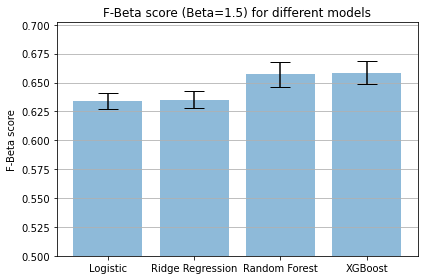

In [25]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, fbeta_15s, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('F-Beta score')
ax.set_xticks(x_pos)
ax.set_xticklabels([model_names[x] for x in models])
ax.set_title('F-Beta score (Beta=1.5) for different models')
ax.set_ylim(bottom=0.5)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig(figures_dir + 'bar_plot_with_error_bars.png')
plt.show()

The XGBoost model had the highest test set performance and was chosen as the model of choice. The best set of parameters were selected as the parameters that performed the best on a holdout set.

In [35]:
# set(MODEL_EVALUATIONS['xgboost']['best_models'])

After choosing the best model and hyperparameter choice, the model was retrained on new splits over 10 new random states. For each split, 80% of the data was allocated to training and 20% was allocated to testing. For each random state, the preprocessed test set, model, and baseline accuracy score were recorded.